# Neural Network Classification

### Dealing with the dataset

In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pathlib import Path

# Creating a sintetic dataset
X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

# Turning the data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Normalize the input data
X = (X - X.min()) /(X.max() - X.min())
y = (y - y.min()) /(y.max() - y.min())

# Spliting the dataset into traing and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a dataframe with the dataset
df = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'y': y})
display(df)

/home/matheus/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,X1,X2,y
0,0.866070,0.617581,1.0
1,0.148119,0.580399,1.0
2,0.119964,0.589917,1.0
3,0.320395,0.836902,1.0
4,0.717747,0.081304,0.0
...,...,...,...
995,0.623557,0.956327,0.0
996,0.042359,0.378080,0.0
997,0.442476,0.122521,1.0
998,0.826197,0.142728,0.0


X.shape: torch.Size([1000, 2])     y.shape: torch.Size([1000])

Values for one sample
X:  tensor([0.8661, 0.6176])
y:  [tensor(1.)]


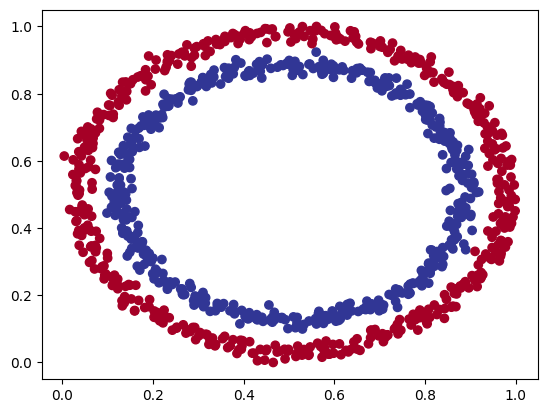

In [2]:
print(f'X.shape: {X.shape}     y.shape: {y.shape}\n')
print(f'Values for one sample\nX:  {X[0]}\ny:  {[y[0]]}')

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

### Building the model

In [3]:
# Checking if the GPU is availible to run the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device availible: ', device)


# Model
class CircleModel0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(2, 5)
        self.layer_2 = nn.Linear(5, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x  ->  layer_1  ->  layer_2  ->  output
        return self.layer_2(self.layer_1(x))


# Intanciating the model
model_0 = CircleModel0().to(device)
dict(model_0.state_dict())


device availible:  cpu


{'layer_1.weight': tensor([[ 0.1499,  0.3485],
         [-0.1010,  0.5331],
         [-0.2003, -0.5683],
         [ 0.2725,  0.5472],
         [-0.6476,  0.1146]]),
 'layer_1.bias': tensor([-0.4639,  0.1647, -0.6216, -0.3277, -0.6168]),
 'layer_2.weight': tensor([[ 0.0880,  0.2589, -0.4313, -0.2796, -0.4332]]),
 'layer_2.bias': tensor([0.0509])}

In [4]:
# Making predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'\nFirst 5 predictions: \n{untrained_preds[:5].tolist()}')
print(f'\nFirst 5 labels:\n{y_test[:5].tolist()}')


First 5 predictions: 
[[0.9467048645019531], [1.0261008739471436], [0.8033767938613892], [0.9870482087135315], [0.9062376022338867]]

First 5 labels:
[1.0, 0.0, 1.0, 0.0, 1.0]


### Setting loss, optimizer and evaluation functions

In [5]:
# Loss function (sigmoid activation function builtin)
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate the accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Training the model

In [6]:
# Garant the reprodutibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put the data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Number of epochs the model will be trained
epochs = 100


# Training loop
ls = []
ac = []
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Make the prediction with the forward method
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits  ->  pred prob  ->  pred labels

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    ls.append(float(loss))

    # 3. Turn the gradients to zero
    optimizer.zero_grad()

    # 4. Calculate the gradients
    loss.backward()

    # 5. Update the parameters according to the gradients
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Do the prediction
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    # Printing the results
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}   |||   Loss: {loss:.5f}, Acc: {acc:.2f}%   |   Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')


Epoch: 0   |||   Loss: 0.79695, Acc: 50.00%   |   Test loss: 0.78556, Test acc: 50.00%
Epoch: 10   |||   Loss: 0.71201, Acc: 50.00%   |   Test loss: 0.71130, Test acc: 50.00%
Epoch: 20   |||   Loss: 0.69699, Acc: 50.00%   |   Test loss: 0.69747, Test acc: 50.00%
Epoch: 30   |||   Loss: 0.69395, Acc: 50.00%   |   Test loss: 0.69446, Test acc: 50.00%
Epoch: 40   |||   Loss: 0.69329, Acc: 50.00%   |   Test loss: 0.69375, Test acc: 50.00%
Epoch: 50   |||   Loss: 0.69314, Acc: 57.75%   |   Test loss: 0.69357, Test acc: 57.00%
Epoch: 60   |||   Loss: 0.69311, Acc: 53.25%   |   Test loss: 0.69353, Test acc: 49.00%
Epoch: 70   |||   Loss: 0.69309, Acc: 52.38%   |   Test loss: 0.69353, Test acc: 47.50%
Epoch: 80   |||   Loss: 0.69309, Acc: 51.88%   |   Test loss: 0.69354, Test acc: 47.00%
Epoch: 90   |||   Loss: 0.69308, Acc: 51.50%   |   Test loss: 0.69356, Test acc: 47.50%


### Make predictions and evaluating the model

In [7]:
# Downloading helper functions from Learn Pytorch repo
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download.')
else:
    print('Downloading helper_functios.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download.


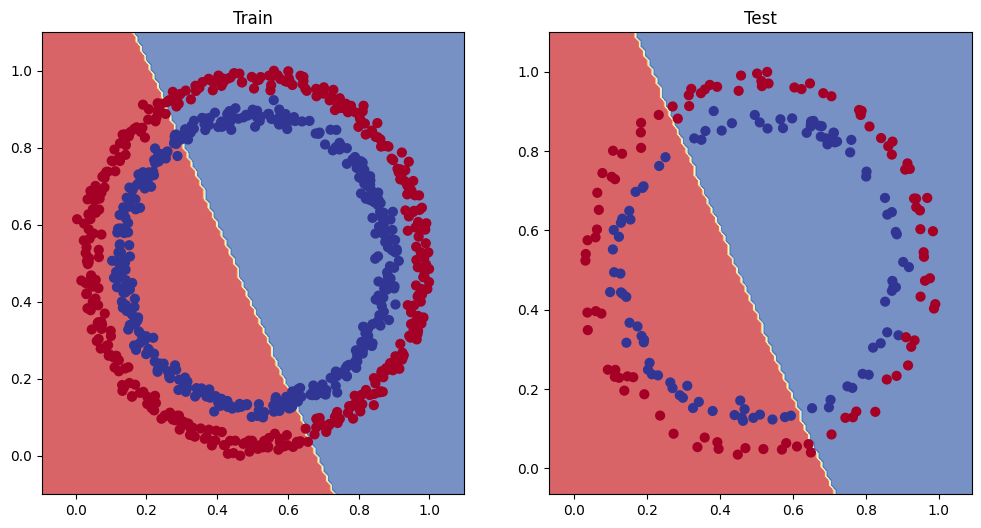

In [8]:
# Plotin the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

### A model with non-linear activation function

In [9]:
# Creating a new class to the model
class CircleModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Instanciating another model
model_1 = CircleModel1().to(device)
model_1

CircleModel1(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

### Training the new model

In [14]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.5)

# Write a training and evaluation loop for the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1500

# Putting the data on the the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> prediction labels

    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Back propagation
    loss.backward()

    # 5. Gradient descent
    optimizer.step()


    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    # Printing the results
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:<5d}   | Loss: {loss:.5f}, Acc: {acc:<.2f}%    | Test loss: {test_loss:.5f},  Test acc: {test_acc:.2f}%')

Epoch: 0       | Loss: 0.00086, Acc: 100.00%    | Test loss: 0.00527,  Test acc: 100.00%
Epoch: 100     | Loss: 0.00084, Acc: 100.00%    | Test loss: 0.00520,  Test acc: 100.00%
Epoch: 200     | Loss: 0.00081, Acc: 100.00%    | Test loss: 0.00512,  Test acc: 100.00%
Epoch: 300     | Loss: 0.00079, Acc: 100.00%    | Test loss: 0.00506,  Test acc: 100.00%
Epoch: 400     | Loss: 0.00077, Acc: 100.00%    | Test loss: 0.00499,  Test acc: 100.00%
Epoch: 500     | Loss: 0.00076, Acc: 100.00%    | Test loss: 0.00493,  Test acc: 100.00%
Epoch: 600     | Loss: 0.00074, Acc: 100.00%    | Test loss: 0.00487,  Test acc: 100.00%
Epoch: 700     | Loss: 0.00072, Acc: 100.00%    | Test loss: 0.00482,  Test acc: 100.00%
Epoch: 800     | Loss: 0.00070, Acc: 100.00%    | Test loss: 0.00475,  Test acc: 100.00%
Epoch: 900     | Loss: 0.00069, Acc: 100.00%    | Test loss: 0.00468,  Test acc: 100.00%
Epoch: 1000    | Loss: 0.00067, Acc: 100.00%    | Test loss: 0.00464,  Test acc: 100.00%
Epoch: 1100    | Loss

### Visualizing the results

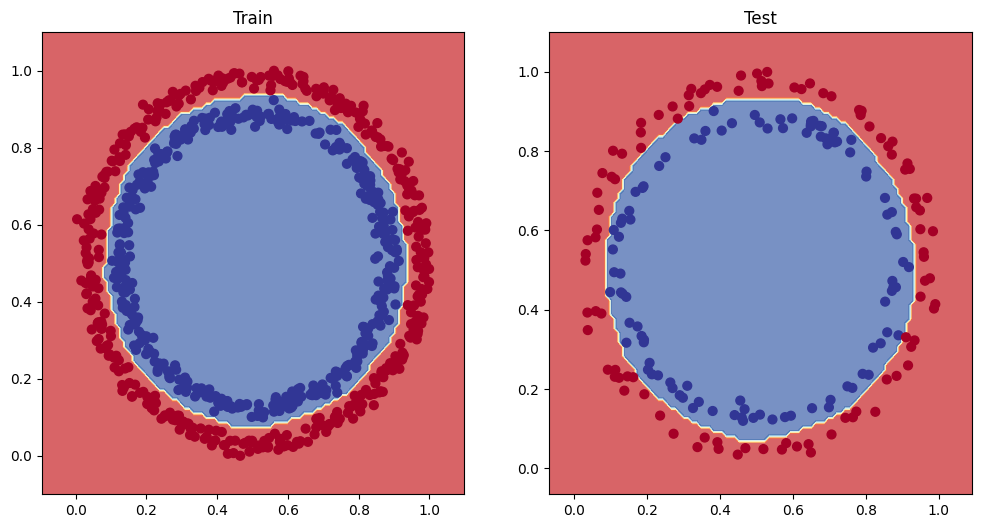

In [15]:
# Plotin the decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)